In [1]:
from convokit import Corpus, Conversation, Utterance, Speaker, FightingWords, download
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neural_network import MLPClassifier

## 1. Data Pre-Processing

In [2]:
# Same as Checkpoint 1:
# Filter for the years of the Supreme Court Case corpus that are a part
# of the Rehnquist 7 and Roberts 4 natural courts

rehnquist_years = [i for i in range(1994,2006)]
rehnquist_corpus = None
for year in rehnquist_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not rehnquist_corpus:
        rehnquist_corpus = corp
    else:
        rehnquist_corpus = Corpus.merge(rehnquist_corpus, corp)

roberts_years = [i for i in range(2010,2017)]
roberts_corpus = None
for year in roberts_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not roberts_corpus:
        roberts_corpus = corp
    else:
        roberts_corpus = Corpus.merge(roberts_corpus, corp)


# Using the start and end dates of both natural courts, filter for the
# relevant case ids, removing cases belonging to the previous or the following courts
with open('../data/cases.json', "r") as f:
    data = [json.loads(line) for line in f]
    begin_date_rehn7 = datetime.strptime('Aug 3, 1994', '%b %d, %Y')
    end_date_rehn7 = datetime.strptime('Sep 28, 2005','%b %d, %Y')
    begin_date_rob4 = datetime.strptime('Aug 7, 2010', '%b %d, %Y')
    end_date_rob4 = datetime.strptime('Feb 13, 2016', '%b %d, %Y')
    case_ids_rehn7 = []
    case_ids_rob4 = []
    for case in data:
        str_date = case["decided_date"]
        if isinstance(str_date, str):
            num_date = datetime.strptime(str_date, '%b %d, %Y')
            if num_date >= begin_date_rehn7 and num_date <= end_date_rehn7:
                case_ids_rehn7.append(case["id"])
            if num_date >= begin_date_rob4 and num_date <= end_date_rob4:
                case_ids_rob4.append(case["id"])
with open('../data/filtered_cases.json', "w") as f2:
    json.dump({"rehn7": case_ids_rehn7,"rob4": case_ids_rob4}, f2, indent=1)

rehnquist_corpus = rehnquist_corpus.filter_conversations_by(lambda u: str(u.meta["case_id"]) in case_ids_rehn7) # complete rehnquist 7 court corpus
roberts_corpus = roberts_corpus.filter_conversations_by(lambda u: u.meta["case_id"] in case_ids_rob4) # complete roberts 4 court corpus

Dataset already exists at /Users/betty/.convokit/downloads/supreme-1994
Dataset already exists at /Users/betty/.convokit/downloads/supreme-1995
Dataset already exists at /Users/betty/.convokit/downloads/supreme-1996
Dataset already exists at /Users/betty/.convokit/downloads/supreme-1997
Dataset already exists at /Users/betty/.convokit/downloads/supreme-1998
Dataset already exists at /Users/betty/.convokit/downloads/supreme-1999
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2000
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2001
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2002
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2003
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2004
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2005
Dataset already exists at /Users/betty/.convokit/downloads/supreme-2010
Dataset already exists at /Users/betty/.convokit/downloads/supre

In [3]:
# Get the conversation dataframe for each court
rehnquist_convo_df = rehnquist_corpus.get_conversations_dataframe()
roberts_convo_df = roberts_corpus.get_conversations_dataframe()

# Use meta.win_side to split each conversation dataframe into 
# wins (1) - petitioning party received a favorable disposition, and
# losses (0) - no favorable disposition for petitioning party
rehnquist_wins_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 1, :]
rehnquist_losses_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 0, :]

roberts_wins_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 1, :]
roberts_losses_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 0, :]

## Baseline Setting
Before beginning the process to create predictions, we establish a baseline to help us evaluate our model's performance. In both courts, the majority of case outcomes is 1 - petitioning party received a favorable disposition: slightly above 60% of both court outcomes. The fact that there is not a perfect 50/50 split between win (1) and lose (0) outcomes is not surprising since the Supreme Court selects cases to hear. This likely biases the Supreme Court to take more cases where the Court has an interest in overturning a lower court's decision. Conversely, the Supreme Court would be less likely to select cases where a lower court's existing decision would simply be upheld or affirmed.

### Findings
We found that for the Rehnquist 7 Court, there are a total of 862 cases, 543 of which had an outcome of 1. This means that if we were to predict a win (1) for every case, we would be correct 63% of the time.

For the Roberts 4 Court there are a total of 351 cases, 225 of which won. If we were to perdict a win (1) for every case, we would be correct 64% of the time. 

Therefore our model will need to perform at these baselines or better. 

In [4]:
# Calculate baseline probabilities: identify the majority outcome
# for each court and the probability of that outcome

# Rehnquist 7 Court baseline: 543/862 = ~ 63%
# Roberts 4 Court baseline: 225/351 = ~ 64%
rehn7_outcome_count = rehnquist_convo_df.groupby('meta.case_id', as_index=True).agg({'meta.win_side': 'max'}).loc[: 'meta.win_side'].value_counts()
rob4_outcome_count = roberts_convo_df.groupby('meta.case_id', as_index=True).agg({'meta.win_side': 'max'}).loc[: 'meta.win_side'].value_counts()

print(rehn7_outcome_count)
print(rob4_outcome_count)

meta.win_side
1.0              543
0.0              318
2.0                1
Name: count, dtype: int64
meta.win_side
1                225
0                126
Name: count, dtype: int64


### Data Preparation - Join, Stratification, Clean, Train/Test Split
We chose the following initial data preparation process based on [this resource](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) and determined our train/test split based on class dicussions.

**N-gram vectorization -> bigram range -> tf-idf count mode -> f_classif scoring -> top 7k feature selection.** 

To get the text and label data necessary to train the model - the first step of which is N-gram vectorization, we need to join utterance-level data (text strings) with conversation-level data (outcomes) by case-ids, clean the data to remove outliers in case outcomes (2 and Nones), and finally split the data (approximately 70/20/10). By using random assignment, we attempt to prevent overfitting on certain years, certain cases, or certain speaker types. By using stratification, we balance speaker types across train/validation/test during splitting. 

The Rehnquist 7 Court case outcomes include 2 - favorable disposition for petitioning party unclear - and Nones. The utterances and conversations with these court outcomes are filtered out.

Using the train_test_split, we randomly assign 70% of the utterances to the training set, and then split the remaining data into test and validation so that approximately 18% of the whole data set is set aside for validation and thee remaining 12% is set aside for testing. 

We select the 7,000 most relevant features, which accounts for ~1/5 of the total ~37,000 features (n-grams) we extract from the Roberts justice dataset.


In [5]:
#  Get the dataframes of utterances from the Rehnquist 7 and Roberts 4 corpuses
rehnquist_utterances_df= rehnquist_corpus.get_utterances_dataframe()
roberts_utterances_df= roberts_corpus.get_utterances_dataframe()

# Filter out conversations with only 1 utt
unique_roberts = roberts_utterances_df.loc[:, 'conversation_id'].value_counts()
roberts_utterances_df = roberts_utterances_df.loc[roberts_utterances_df['conversation_id'].map(unique_roberts) > 1,:]

unique_rehnquist = rehnquist_utterances_df.loc[:, 'conversation_id'].value_counts()
rehnquist_utterances_df = rehnquist_utterances_df.loc[rehnquist_utterances_df['conversation_id'].map(unique_rehnquist) > 1,:]


# join utterance dataframes with conversation dataframes on case ids
rehn_merge = rehnquist_utterances_df.merge(rehnquist_convo_df, how = 'left', on = 'meta.case_id')
rob_merge = roberts_utterances_df.merge(roberts_convo_df, how = 'left', on = 'meta.case_id')

rehn_merge.loc[:, 'meta.win_side'].unique()
rob_merge.loc[:, 'meta.win_side'].unique()

# drop rows where case outcome is 2 or None
rehn_merge.drop(rehn_merge[rehn_merge['meta.win_side'] == 2].index, inplace = True)
rehn_merge.drop(rehn_merge[rehn_merge['meta.win_side'].isna()].index, inplace = True)

# to evaluate the need to stratify, use meta.speaker_type column to assess
# distribution of speaker types (J: justice, A: advocate) across utterances
rehn_merge.loc[:, 'meta.speaker_type'].value_counts()
rob_merge.loc[:, 'meta.speaker_type'].value_counts()

# roberts court: J - 44655, A - 41397
# rehnquist court: J - 106126A, A - 106777

# we filter out nulls, to allow stratification by speaker
rob_merge = rob_merge.loc[rob_merge.loc[:, 'meta.speaker_type'].notnull()]
rehn_merge = rehn_merge.loc[rehn_merge.loc[:, 'meta.speaker_type'].notnull()]

# can add more info about the nulls (13000 for rehnquist, 300 for roberts)

# keep only text, meta.win_side, and meta.speaker_type columns
rob_final_df = rob_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type']]
rehn_final_df = rehn_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type']]

In [6]:
# also create df including only justices' utt
rob_final_df_J = rob_final_df.loc[rob_final_df.loc[:, 'meta.speaker_type'] == 'J', :]
rehn_final_df_J = rehn_final_df.loc[rehn_final_df.loc[:, 'meta.speaker_type'] == 'J', :]
display(rob_final_df_J)

,text,meta.win_side,meta.speaker_type
0,"We will hear argument next in Case 09-479, Abb...",0,J
2,"Well, if the text of this is so clear, how is ...",0,J
4,"But they are not the same, are they?",0,J
6,Isn't it -- there is a missing prepositional p...,0,J
8,"So that means there would be no punishment, ad...",0,J
...,...,...,...
86904,"Just to follow up: In -- in recent years, is i...",1,J
86906,"No, no.\nI'm just talking statistically.",1,J
86908,"When you say ""taking"" them, I mean, they're be...",1,J
86910,"On the issue of political sensitivity, if it g...",1,J


In [7]:
# first train/test split - 70% train, 30% test
rehn_train, rehn_test = train_test_split(rehn_final_df,
                                         train_size=0.7,
                                         stratify=rehn_final_df.loc[:, 'meta.speaker_type'])
rob_train, rob_test = train_test_split(rob_final_df,
                                       train_size=0.7,
                                       stratify=rob_final_df.loc[:, 'meta.speaker_type'])

# second train/test split to create validation set from test set (60% validation, 40% test)
rehn_valid, rehn_test = train_test_split(rehn_test,
                                         train_size=0.6,
                                         stratify=rehn_test.loc[:, 'meta.speaker_type'])
rob_valid, rob_test = train_test_split(rob_test,
                                       train_size=0.6,
                                       stratify=rob_test.loc[:, 'meta.speaker_type'])

# overall, we now have a roughly 70/20/10 split for train, validate, and test for each corpus

In [8]:
# Checking stratification - speaker types look balanced across both training sets 
print(rehn_train.loc[:, 'meta.speaker_type'].value_counts())
print(rob_train.loc[:, 'meta.speaker_type'].value_counts())

meta.speaker_type
A    74744
J    74288
Name: count, dtype: int64
meta.speaker_type
J    31257
A    28978
Name: count, dtype: int64


In [9]:
roberts_utterance_vect_train = rob_train.loc[:, 'text']
roberts_label_vect_train = rob_train.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
roberts_utterance_vect_valid = rob_valid.loc[:, 'text']
roberts_label_vect_valid = rob_valid.loc[:, 'meta.win_side'].astype(float).to_numpy()

rehnquist_utterance_vect_train = rehn_train.loc[:, 'text']
rehnquist_label_vect_train = rehn_train.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
rehnquist_utterance_vect_valid = rehn_valid.loc[:, 'text']
rehnquist_label_vect_valid = rehn_valid.loc[:, 'meta.win_side'].astype(float).to_numpy()

In [10]:
# do the same for df with only J
rehn_train_J, rehn_test_J = train_test_split(rehn_final_df_J, train_size=0.7)
rob_train_J, rob_test_J = train_test_split(rob_final_df_J, train_size=0.7)

# second train/test split to create validation set from test set (60% validation, 40% test)
rehn_valid_J, rehn_test_J = train_test_split(rehn_test_J, train_size=0.6)
rob_valid_J, rob_test_J = train_test_split(rob_test_J, train_size=0.6)

roberts_utterance_vect_train_J = rob_train_J.loc[:, 'text']
roberts_label_vect_train_J = rob_train_J.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
roberts_utterance_vect_valid_J = rob_valid_J.loc[:, 'text']
roberts_label_vect_valid_J = rob_valid_J.loc[:, 'meta.win_side'].astype(float).to_numpy()

rehnquist_utterance_vect_train_J = rehn_train_J.loc[:, 'text']
rehnquist_label_vect_train_J = rehn_train_J.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
rehnquist_utterance_vect_valid_J = rehn_valid_J.loc[:, 'text']
rehnquist_label_vect_valid_J = rehn_valid_J.loc[:, 'meta.win_side'].astype(float).to_numpy()

### Features engineering
Following the steps from [this resource](https://developers.google.com/machine-learning/guides/text-classification/step-2-5). Since at this point, the orderinng of words is not the question of interest, we chose the "bag-of-words" approach and used the following steps for data preprocessing:

1) Tokenizing: Using words (as opposed to characters) and splitting utterances into 1-word and 2-word (unigram and bigram) tokens
    - we also added a few specific rules to how the words were processed such as: keeping question marks but removing other punctuation that does not carry meaning, removing numbers, and including the standard nltk english stop words so that (similar to what tf-idf is doing), we can remove words that do not hold meaning in this context. 
2) Vectorizing: converting tokens into numerical vectors using count encoding (as opposed to one-hot encoding)
    - for our case we chose to use [tf-idf encoding](https://en.wikipedia.org/wiki/Tf%e2%80%93idf) to represent the tokens in a manner that is reflective of their importance as this seems to be the general standard for encoding.
3) Feature selection: using the tokens that have now been encoded according to their importance, we use f_classif (f-value classification) to regress them on their corresponding training labels and determine which ones have the best fit in this training set. 
    - we then choose the top k features that have been classified as having the best fit. Although k=20,000 is the recommended k, we chose 7000 since we are working with a relatively smaller number of features to model off of. 


**Vectorization Parameters**

In [11]:
# Range (inclusive) of n-gram sizes for tokenizing text (using unigrams and bigrams).
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 2K features.
TOP_K = 7000

# Whether text should be split into word or character n-grams ('word' or 'char')
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

**Vectorizing**

In [12]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'stop_words': list(ENGLISH_STOP_WORDS),
            'token_pattern': r"(?u)\b\w\w+\b|\?", # preserving punctuation (might need to remove the strip accents part)
    }

    # The TfidfVectorizer instance vectorizer is created with the specified keyword arguments
    vectorizer = TfidfVectorizer(**kwargs)

    # The fit_transform() method is called on vectorizer using train_texts as the input.
    # This step collects and learns the vocabulary from the training texts and vectorizes 
    # the training texts accordingly, assigning the resulting matrix to x_train.
    x_train = vectorizer.fit_transform(train_texts).astype('float32')


    # The transform() method is called on vectorizer using val_texts as the input.
    # This step uses the previously learned vocabulary to vectorize the validation
    # texts, assigning the resulting matrix to x_val.
    x_val = vectorizer.transform(val_texts).astype('float32')

    # The vocabulary_ attribute of the vectorizer is assigned to the vocabulary variable.
    # This vocabulary dictionary represents the learned vocabulary, which was collected from the training texts.
    vocabulary = vectorizer.vocabulary_

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    selected_features = selector.get_support()
    
    # Create a dictionary counting the relevance of the k selected n-grams
    vocabulary_sel = {ngram: index for ngram, index in vocabulary.items() if selected_features[index]}
    ngram_counts = {}
    for ngram, index in vocabulary_sel.items():
        count = x_train[:, index].sum()
        ngram_counts[ngram] = count

    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')

    return x_train, x_val, ngram_counts

In [13]:
rob_vect_train, rob_vect_valid, rob_voc = ngram_vectorize(roberts_utterance_vect_train,
                                                          roberts_label_vect_train,
                                                          roberts_utterance_vect_valid)

rehn_vect_train, rehn_vect_valid, rehn_voc = ngram_vectorize(rehnquist_utterance_vect_train,
                                                             rehnquist_label_vect_train,
                                                             rehnquist_utterance_vect_valid)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [14]:
rob_vect_train_J, rob_vect_valid_J, rob_voc_J = ngram_vectorize(roberts_utterance_vect_train_J,
                                                                roberts_label_vect_train_J,
                                                                roberts_utterance_vect_valid_J)

rehn_vect_train_J, rehn_vect_valid_J, rehn_voc_J = ngram_vectorize(rehnquist_utterance_vect_train_J,
                                                                   rehnquist_label_vect_train_J,
                                                                   rehnquist_utterance_vect_valid_J)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


#### Top K Features

In [15]:
# Print top-k features
rehnquist_voc = dict(sorted(rehn_voc.items(), key=lambda item: item[1], reverse = True))
roberts_voc = dict(sorted(rob_voc.items(), key=lambda item: item[1], reverse = True))

rehn_voc_df = pd.DataFrame.from_dict(rehnquist_voc, orient = 'index')
rob_voc_df = pd.DataFrame.from_dict(roberts_voc, orient = 'index')

print("Rehnquist 7 Court Top-K Features:", rehn_voc_df.head(10))

print("\nRoberts 4 Court Top-K Features:", rob_voc_df.head(10))

Rehnquist 7 Court Top-K Features:                     0
yes       4542.816406
honor     2415.663818
justice   1421.051880
state     1344.711426
statute   1075.658813
law       1048.602051
does      1023.701416
federal    836.333252
congress   822.869751
going      762.127075

Roberts 4 Court Top-K Features:                    0
?        1973.533447
yes      1552.201538
court     904.378113
honor     856.139954
case      854.614197
justice   674.810730
correct   575.940918
state     534.027161
going     492.076599
counsel   436.226196


In [16]:
# Print top-k features for judges only
rehnquist_voc_J = dict(sorted(rehn_voc_J.items(), key=lambda item: item[1], reverse = True))
roberts_voc_J = dict(sorted(rob_voc_J.items(), key=lambda item: item[1], reverse = True))

rehn_voc_df_J = pd.DataFrame.from_dict(rehnquist_voc_J, orient = 'index')
rob_voc_df_J = pd.DataFrame.from_dict(roberts_voc_J, orient = 'index')

print("Rehnquist 7 Court Top-K Features (J only):", rehn_voc_df_J.head(10))

print("\nRoberts 4 Court Top-K Features (J only):", rob_voc_df_J.head(10))

Rehnquist 7 Court Top-K Features (J only):                       0
yes         1277.376709
state        706.744263
does         631.840698
statute      570.419434
law          568.376709
didn         487.933411
federal      433.273132
want         425.289581
way          383.733826
government   376.371277

Roberts 4 Court Top-K Features (J only):                          0
?              1572.805542
right           570.179626
case            476.464630
know            387.277954
counsel         377.067505
thank           323.754150
court           313.901672
going           299.511292
state           284.193420
thank counsel   258.522827


We note there are differences in the most relevant n-grams when using the aggregate dataset compared to using only the justices' utterances. Notably, affirmative words ('yes', 'okay') appear in the second case for Rehnquist court. It is however worth noting that most of the ngrams remain significant in the subset of justices.

## 2. Building the Model
Since we used the n-gram ("bag-of-words") approach for data processing (instead of a sequential approach), we can use logistic regression, simple multi-layer perceptrons (MLPs), or full neural networks, gradient boosted trees or support vector machines (SVM). 

We chose to test our preprocessed training and test data using a logistic regression to quickly get a sense of how our data is performing, and to compare it to the initial benchmarks that we established above.


### Baseline: Basic Logistic Regression

In [17]:
rehnquist_jlg = LogisticRegression().fit(rehn_vect_train, rehnquist_label_vect_train)
rehnquist_predictions = rehnquist_jlg.predict(rehn_vect_valid)

roberts_jlg = LogisticRegression().fit(rob_vect_train, roberts_label_vect_train)
roberts_predictions = roberts_jlg.predict(rob_vect_valid)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [18]:
print("Basic Logistic Regression")
print("Rehnquist 7 Court Accuracy Score:", accuracy_score(rehnquist_label_vect_valid, rehnquist_predictions))
print("Roberts 4 Court Accuracy Score:", accuracy_score(roberts_label_vect_valid, roberts_predictions))

Basic Logistic Regression
Rehnquist 7 Court Accuracy Score: 0.6906215750743698
Roberts 4 Court Accuracy Score: 0.7355542643166118


In [19]:
rehnquist_jlg_J = LogisticRegression().fit(rehn_vect_train_J, rehnquist_label_vect_train_J)
rehnquist_predictions_J = rehnquist_jlg_J.predict(rehn_vect_valid_J)

roberts_jlg_J = LogisticRegression().fit(rob_vect_train_J, roberts_label_vect_train_J)
roberts_predictions_J = roberts_jlg_J.predict(rob_vect_valid_J)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [20]:
print("Basic Logistic Regression")
print("Rehnquist 7 Court Accuracy Score (J only):", accuracy_score(rehnquist_label_vect_valid_J, rehnquist_predictions_J))
print("Roberts 4 Court Accuracy Score (J only):", accuracy_score(roberts_label_vect_valid_J, roberts_predictions_J))

Basic Logistic Regression
Rehnquist 7 Court Accuracy Score (J only): 0.6799811538058842
Roberts 4 Court Accuracy Score (J only): 0.7175914406568799


Note that, even if our baseline model accuracy exceeds the 60% previously explained threshold, such accuracy slightly diminishes when considering only the justices. This is surprising, but seems to suggest that advocates' utterances are relevant and must be preserved. 

#### Multi-Layer Perceptron

In [21]:
classif = MLPClassifier(hidden_layer_sizes=(30, 20, 10),
                           solver='adam', 
                           activation='relu', 
                           learning_rate='adaptive', 
                           alpha=0.0001)

classif.fit(rehn_vect_train, rehnquist_label_vect_train)
rehnquist_predictions_MLP = classif.predict(rehn_vect_valid)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
classif.fit(rob_vect_train, roberts_label_vect_train)
roberts_predictions_MLP = classif.predict(rob_vect_valid)

/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
print("Multi-layer Perceptron")
print("Rehnquist 7 Court Accuracy Score:", accuracy_score(rehnquist_label_vect_valid, rehnquist_predictions_MLP))
print("Roberts 4 Court Accuracy Score:", accuracy_score(roberts_label_vect_valid, roberts_predictions_MLP))

Multi-layer Perceptron
Rehnquist 7 Court Accuracy Score: 0.6884035279995825
Roberts 4 Court Accuracy Score: 0.7331009103234554


In [24]:
# classif.fit(rehn_vect_train_J, rehnquist_label_vect_train_J)  # takes too long
# rehnquist_predictions_MLP_J = classif.predict(rehn_vect_valid_J)

classif.fit(rob_vect_train_J, roberts_label_vect_train_J)
roberts_predictions_MLP_J = classif.predict(rob_vect_valid_J)

print("Multi-layer Perceptron")
# print("Rehnquist 7 Court Accuracy Score (J only):", accuracy_score(rehnquist_label_vect_valid_J, rehnquist_predictions_MLP_J))
print("Roberts 4 Court Accuracy Score (J only):", accuracy_score(roberts_label_vect_valid_J, roberts_predictions_MLP_J))

Multi-layer Perceptron
Roberts 4 Court Accuracy Score (J only): 0.7072654889275939


/Users/betty/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


When comparing the accuracy of our model for all the utterances and for the subset of judges' utterances only, we can't find significant differences: what is more, even if the accuracy is over our 60% threshold, it has decreased almost 3 p.p. compared to the use of the whole dataset. In line with our results when analyzing the n-grams, this seems to indicate that the utterances of the advocates are relevant and must be included in the model.

Hence, we will only use the aggregate dataset for the last part.

# 3. Performance evaluation

We focused on a) a logistic regression model and b) a multilayer perceptron model with 3 hidden layers and reLU for both courts. Below is our evaluation of these models for each court. 

All models outperform the baseline, which was 64% for Rehnquist Court and 63% for the Roberts Court. 

Basic Logistic Regression
* Rehnquist 7 Court Accuracy Score: 0.6906215750743698
* Roberts 4 Court Accuracy Score: 0.7355542643166118

Multi-layer Perceptron
* Rehnquist 7 Court Accuracy Score: 0.6884035279995825
* Roberts 4 Court Accuracy Score: 0.7331009103234554

The MLP slightly underperforms the basic logistic regression model in Accuracy Scores, and significantly underperforms the basic logistic regression model in AUC.

In the case of the Rehnquist Court - Accuracy Scores are a) 0.69 and b) 0.68. In the case of the Roberts Court - Accuracy Scores are a) 0.74 and b) 0.73.
In the case of the Rehnquist Court - AUC is a) 0.69 and b) 0.69. In the case of the Roberts Court - the AUC is a) 0.74 and b) 0.73.

All models were an improvement compared to the baseline, but there is room for iteration as we tune parameters in the next phase.

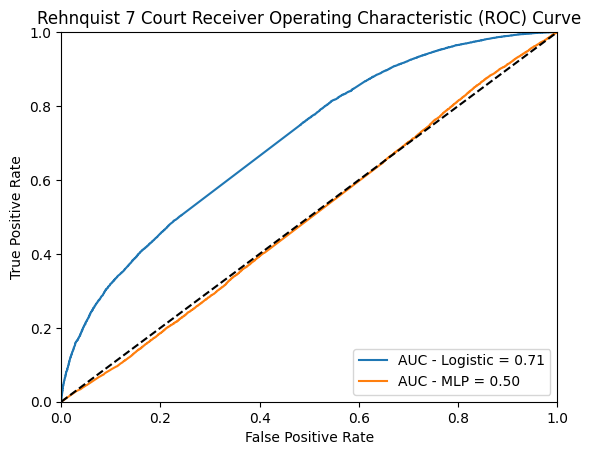

In [25]:
# rehnquist court performance - logistic regression
y_pred_proba = rehnquist_jlg.predict_proba(rehn_vect_valid)[:,1]
fpr, tpr, thresholds = roc_curve(rehnquist_label_vect_valid, y_pred_proba)
auc_score = roc_auc_score(rehnquist_label_vect_valid, y_pred_proba)

# rehnquist court performance - multi-layer perceptron
y_pred_proba2 = classif.predict_proba(rehn_vect_valid)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(rehnquist_label_vect_valid, y_pred_proba2)
auc_score2 = roc_auc_score(rehnquist_label_vect_valid, y_pred_proba2)

plt.plot(fpr, tpr, label='AUC - Logistic = %.2f' % auc_score)
plt.plot(fpr2, tpr2, label='AUC - MLP = %.2f' % auc_score2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Rehnquist 7 Court Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

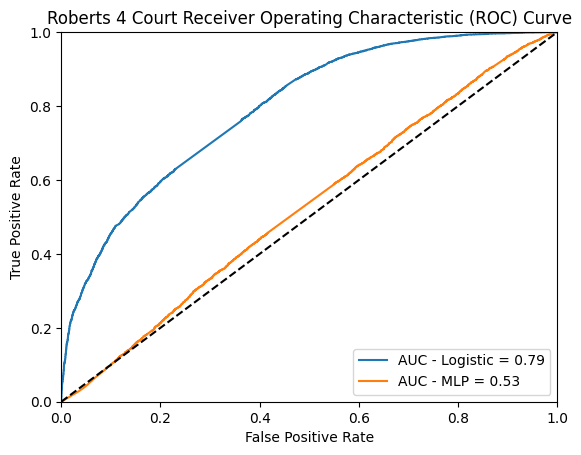

In [26]:
# roberts court performance - logistic regression
y_pred_proba = roberts_jlg.predict_proba(rob_vect_valid)[:,1]
fpr, tpr, thresholds = roc_curve(roberts_label_vect_valid, y_pred_proba)
auc_score = roc_auc_score(roberts_label_vect_valid, y_pred_proba)

# roberts court performance - multi-layer perceptron
y_pred_proba2 = classif.predict_proba(rob_vect_valid)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(roberts_label_vect_valid, y_pred_proba2)
auc_score2 = roc_auc_score(roberts_label_vect_valid, y_pred_proba2)

plt.plot(fpr, tpr, label='AUC - Logistic = %.2f' % auc_score)
plt.plot(fpr2, tpr2, label='AUC - MLP = %.2f' % auc_score2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roberts 4 Court Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()